In [80]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim


from nltk.tokenize import word_tokenize 
from nltk.tokenize import TweetTokenizer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile

from tempfile import mkdtemp
import pickle
import joblib

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

import os
import yaml
import collections
import scattertext as st
import math

from tqdm import tqdm_notebook as tqdm
tqdm().pandas() 

with open('data_pickle','rb') as file:
    processed = pickle.load(file)


with open(r'intents.yml') as file:
    intents = yaml.load(file, Loader=yaml.FullLoader)


print(f'\nintents:\n{intents}')
print(f'\nprocessed:\n{processed.head()}')

0it [00:00, ?it/s]


intents:
{'battery': ['battery', 'power'], 'forgot_password': ['password', 'account', 'login'], 'payment': ['credit', 'card', 'payment', 'pay'], 'repair': ['repair', 'fix', 'broken'], 'update': ['update']}

processed:
0       [new, update, make, sure, download, yesterday]
2                [try, reset, setting, restart, phone]
4                                  [iphone, plus, yes]
5                                [need, answer, annoy]
6    [hey, anyone, else, upgraded, issue, capital, ...
Name: inbound_text, dtype: object


In [2]:
intents = {"Greeting": ["Hi there!","Hello"], 
 "Closing":"Thanks for talking", 
 "Promotion":"",
           "Scenarios": {'Last payment': "", "Account details":"", 
                         "Account confirmation": ""},
    "Location": ""}


intents = {'greeting': ['hi', 'hello', 'hey','yo'], 'app': ['app', 'application'],
          'iphone': ['iphone', 'i phone'], 'icloud': ['icloud', 'i cloud'],
          'ios': ['io'], 'battery': ['battery'], 'watch': ['watch'], 'mac': 
           ['mac', 'macbook', 'laptop', 'computer'], 'update': ['update'],
          'troubleshooting': ['problem', 'trouble', 'error'],
          'settings': ['settings', 'setting'], 'music': ['music', 'song', 'playlist'],
          'payment': ['credit','card','payment','pay'], 'bug':['bug'], 'watch': ['tv', 'show'],
          'network': ['internet','connection','network']}

intents_all = {'ios update': ['io', 'update'], 'app update': ['app','update']}


intents = {'update': ['update'], 'battery': ['battery', 'power'], 'forgot_password':['password','account','login'],
          'repair':['repair','fix','broken'],  
           'payment': ['credit','card','payment','pay']}

    

with open('intents.yml', 'w') as outfile:
    yaml.dump(intents, outfile, default_flow_style=False)

print('INTENTS FOR KEYWORD EDA BELOW:\n ------------------------')
for i in intents.items():
    print('Intent: {} \n   Keywords: {}'.format(i[0], " + ".join(i[1])))

INTENTS FOR KEYWORD EDA BELOW:
 ------------------------
Intent: update 
   Keywords: update
Intent: battery 
   Keywords: battery + power
Intent: forgot_password 
   Keywords: password + account + login
Intent: repair 
   Keywords: repair + fix + broken
Intent: payment 
   Keywords: credit + card + payment + pay


In [3]:
ideal = {'Greeting': 'hi hello yo hey whats up howdy morning',
        'Update': 'have problem with update'}

ideal = {'battery': 'battery power', 
         'forgot_password': 'password account login',
         'payment': 'credit card payment pay',
         'update': 'update upgrade',
         'info': 'info information',
         'location': 'nearest apple location store'
        }

def add_extra(current_tokenized_data, extra_tweets):
    
    extra_tweets = pd.Series(extra_tweets)


    print('Converting to string...')
    string_processed_data = current_tokenized_data.progress_apply(" ".join)


    string_processed_data = pd.concat([string_processed_data, extra_tweets], axis = 0)


    tknzr = TweetTokenizer(strip_handles = True, reduce_len = True)

    return string_processed_data


processed_inbound_extra = add_extra(processed, list(ideal.values()))

with open('processed_inbound_extra','wb') as file:
    pickle.dump(processed_inbound_extra,file)


processed_inbound_extra

Converting to string...


  0%|          | 0/95947 [00:00<?, ?it/s]

0              new update make sure download yesterday
2                      try reset setting restart phone
4                                      iphone plus yes
5                                    need answer annoy
6    hey anyone else upgraded issue capital mail ap...
                           ...                        
1                               password account login
2                              credit card payment pay
3                                       update upgrade
4                                     info information
5                         nearest apple location store
Length: 95953, dtype: object

In [4]:
def train_doc2vec(string_data, size, max_epochs, alpha):
    tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) 
                   for i, _d in enumerate(string_data)]
    

    model = Doc2Vec(vector_size=size, alpha=alpha, min_alpha=0.00025, min_count=1, dm =1)

    model.build_vocab(tagged_data)

    for epoch in range(max_epochs):
        print('iteration {0}'.format(epoch))
        model.train(tagged_data, total_examples = model.corpus_count, epochs=model.epochs)
        # Decrease the learning rate
        model.alpha -= 0.0002
        # Fix the learning rate, no decay
        model.min_alpha = model.alpha

    model.save("models_d2v.model")
    print("Model Saved")
    
# Training
model_d2 = train_doc2vec(processed_inbound_extra, size=20, max_epochs = 100, alpha = 0.025)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [81]:
model = Doc2Vec.load("models_d2v.model")

inbound_d2v = np.array([model.docvecs[i] for i in range(processed_inbound_extra.shape[0])])

with open('inbound_d2v.pkl', 'wb') as f:
    pickle.dump(inbound_d2v, f)

inbound_d2v

array([[ 5.0641046 ,  1.4197416 ,  2.1003623 , ...,  3.5559633 ,
         0.55405766,  2.343097  ],
       [ 4.2523437 , -0.99684983, -3.3814054 , ...,  0.8392665 ,
        -0.3987645 , -1.3247259 ],
       [ 2.374191  ,  0.91276926, -3.1392078 , ...,  2.6551425 ,
        -2.6853771 , -1.4280274 ],
       ...,
       [ 1.8137497 ,  0.20235905,  0.04238406, ...,  1.1797376 ,
        -0.7937871 ,  2.046361  ],
       [ 0.33542138,  0.22287495, -0.96385306, ..., -0.3955763 ,
         0.4005592 , -2.5793915 ],
       [ 3.9392512 ,  2.932683  , -1.0454297 , ..., -2.630516  ,
         0.98472685, -0.6960147 ]], dtype=float32)

In [7]:
inbound_d2v.shape

(95953, 20)

In [8]:
intents_repr = {'Battery': ['io', 'drain', 'battery', 'iphone', 'twice', 'fast', 'io', 'help'],
    'Update': ['new', 'update', 'i️', 'make', 'sure', 'download', 'yesterday'],
    'iphone': ['instal', 'io', 'make', 'iphone', 'slow', 'work', 'properly', 'help'],
    'app': ['app', 'still', 'longer', 'able', 'control', 'lockscreen'],
    'mac': ['help','mac','app','store','open','can','not','update','macbook','pro','currently','run','o','x',
  'yosemite'], 'greeting': ['hi', 'hello', 'yo', 'hey', 'whats', 'up']
    }

In [12]:
ideal

{'battery': 'battery power',
 'forgot_password': 'password account login',
 'payment': 'credit card payment pay',
 'update': 'update upgrade',
 'info': 'info information',
 'location': 'nearest apple location store'}

In [20]:
tknzr = TweetTokenizer(strip_handles = True, reduce_len = True)
intents_repr = {k:tknzr.tokenize(v) for k, v in ideal.items()}
print(intents_repr)

with open('intents_repr.yml', 'w') as outfile:
    yaml.dump(intents_repr, outfile, default_flow_style=False)

tags = []

tokenized_processed_inbound = processed_inbound_extra.apply(tknzr.tokenize)

def report_index_loc(tweet, intent_name):
    ''' Takes in the Tweet to find the index for and returns a report of that Tweet index along with what the 
    representative Tweet looks like'''
    try:
        tweets = []
        for i,j in enumerate(tokenized_processed_inbound):
            if j == tweet:
                tweets.append((i, True))
            else:
                tweets.append((i, False))
        index = []
        get_index = [index.append(i[0]) if i[1] == True else False for i in tweets] # Comprehension saves space

        preview = processed_inbound_extra.iloc[index]

       
        tags.append(str(index[0]))
    except IndexError as e:
        print('Index not in list, move on')
        return
        
    return intent_name, str(index[0]), preview

print('TAGGED INDEXES TO LOOK FOR')
for j,i in intents_repr.items():
    try:
        print('\n{} \nIndex: {}\nPreview: {}'.format(*report_index_loc(i,j)))
    except Exception as e:
        print('Index ended')


intents_tags = dict(zip(intents_repr.keys(), tags))
intents_tags

{'battery': ['battery', 'power'], 'forgot_password': ['password', 'account', 'login'], 'payment': ['credit', 'card', 'payment', 'pay'], 'update': ['update', 'upgrade'], 'info': ['info', 'information'], 'location': ['nearest', 'apple', 'location', 'store']}
TAGGED INDEXES TO LOOK FOR

battery 
Index: 95947
Preview: 0    battery power
dtype: object

forgot_password 
Index: 95948
Preview: 1    password account login
dtype: object

payment 
Index: 95949
Preview: 2    credit card payment pay
dtype: object

update 
Index: 95950
Preview: 3    update upgrade
dtype: object

info 
Index: 95951
Preview: 4    info information
dtype: object

location 
Index: 95952
Preview: 5    nearest apple location store
dtype: object


{'battery': '95947',
 'forgot_password': '95948',
 'payment': '95949',
 'update': '95950',
 'info': '95951',
 'location': '95952'}

In [82]:
similar_doc = model.docvecs.most_similar('95947',topn = 1000)
similar_doc[:5]

[('29997', 0.9251912832260132),
 ('15664', 0.8876045942306519),
 ('14200', 0.8798524737358093),
 ('89949', 0.8568456768989563),
 ('59391', 0.8520331382751465)]

In [83]:
train = pd.DataFrame()
processed_inbound = processed_inbound_extra

def generate_intent(target, itag):
    similar_doc = model.docvecs.most_similar(itag,topn = target)
    
    indexes = [int(i[0]) for i in similar_doc]

    return [word_tokenize(tweet) for tweet in list(processed_inbound.iloc[indexes].values)]

for intent_name, itag in intents_tags.items():
    train[intent_name] = generate_intent(1000, itag)


In [84]:
manually_added_intents = {
    'speak_representative': [['talk','human','please'],
                             ['let','me','talk','to','apple','support'], 
                             ['can','i','speak','agent','person']], 
    'greeting': [['hi'],['hello'], ['whats','up'], ['good','morning'],
                 ['good','evening'], ['good','night']],
    'goodbye': [['goodbye'],['bye'],['thank'],['thanks'], ['done']], 
    'challenge_robot': [['robot','human'], ['are','you','robot'],
                       ['who','are','you']]
}


def insert_manually(target, prototype):
   
    factor = math.ceil(target / len(prototype))
    content = prototype * factor
    return [content[i] for i in range(target)]


for intent_name in manually_added_intents.keys():
    train[intent_name] = insert_manually(1000, [*manually_added_intents[intent_name]])

In [85]:
hybrid_intents = {'update':(300,700,[['want','update'], ['update','not','working'], 
                                     ['phone','need','update']], 
                            intents_tags['update']),
                  'info': (800,200, [['need','information'], 
                                       ['want','to','know','about'], ['what','are','macbook','stats'],
                                    ['any','info','next','release','?']], 
                             intents_tags['info']),
                  'payment': (300,700, [['payment','not','through'], 
                                       ['iphone', 'apple', 'pay', 'but', 'not', 'arrive'],
                                       ['how','pay','for', 'this'],
                                       ['can','i','pay','for','this','first']], 
                             intents_tags['payment']),
                  'forgot_password': (600,400, [['forgot','my','pass'], ['forgot','my','login'
                                ,'details'], ['cannot','log','in','password'],['lost','account','recover','password']], 
                             intents_tags['forgot_password'])
                 }

def insert_hybrid(manual_target, generated_target, prototype, itag):
    return insert_manually(manual_target, prototype) + list(generate_intent(generated_target, itag))


for intent_name, args in hybrid_intents.items():
    train[intent_name] = insert_hybrid(*args)

In [86]:

neat_train = pd.DataFrame(train.T.unstack()).reset_index().iloc[:,1:].rename(columns={'level_1':'Intent', 0: 'Utterance'})

neat_train = neat_train[['Utterance','Intent']]


neat_train.to_pickle('train.pkl')


In [87]:

show = lambda x: x.head(10).style.set_properties(**{'background-color': 'white',                                                   
                                    'color': 'lawngreen',                       
                                    'border-color': 'white'})\
.applymap(lambda x: f"color: {'lawngreen' if isinstance(x,str) else 'black'}")\
.background_gradient(cmap='white')

print(train.shape)
show(train)

(1000, 10)


,battery,forgot_password,payment,update,info,location,speak_representative,greeting,goodbye,challenge_robot
0,"['battery', 'phone', 'hot', 'plug', 'min', 'later', 'battery']","['forgot', 'my', 'pass']","['payment', 'not', 'through']","['want', 'update']","['need', 'information']","['deny', 'service', 'stamford', 'ct', 'mall', 'store', 'discirimination', 'dishonest']","['talk', 'human', 'please']",['hi'],['goodbye'],"['robot', 'human']"
1,"['battery', 'drain', 'quickly']","['forgot', 'my', 'login', 'details']","['iphone', 'apple', 'pay', 'but', 'not', 'arrive']","['update', 'not', 'working']","['want', 'to', 'know', 'about']","['store', 'pasadena', 'bad', 'customer', 'service', 'everrrr']","['let', 'me', 'talk', 'to', 'apple', 'support']",['hello'],['bye'],"['are', 'you', 'robot']"
2,"['shutdown', 'way', 'battery']","['cannot', 'log', 'in', 'password']","['how', 'pay', 'for', 'this']","['phone', 'need', 'update']","['what', 'are', 'macbook', 'stats']","['online', 'apple', 'store']","['can', 'i', 'speak', 'agent', 'person']","['whats', 'up']",['thank'],"['who', 'are', 'you']"
3,"['battery', 'dy', 'fast']","['lost', 'account', 'recover', 'password']","['can', 'i', 'pay', 'for', 'this', 'first']","['want', 'update']","['any', 'info', 'next', 'release', '?']","['boston', 'brisbane', 'isin', 'san', 'francisco', 'australia', 'arkansas', 'store', 'near', 'chermside', 'news']","['talk', 'human', 'please']","['good', 'morning']",['thanks'],"['robot', 'human']"
4,"['battery', 'drain', 'faster']","['forgot', 'my', 'pass']","['payment', 'not', 'through']","['update', 'not', 'working']","['need', 'information']","['liverpool', 'store', 'customer', 'service', 'appal']","['let', 'me', 'talk', 'to', 'apple', 'support']","['good', 'evening']",['done'],"['are', 'you', 'robot']"
5,"['iphone', 'charger', 'battery', 'stuck', 'percentage']","['forgot', 'my', 'login', 'details']","['iphone', 'apple', 'pay', 'but', 'not', 'arrive']","['phone', 'need', 'update']","['want', 'to', 'know', 'about']","['horrible', 'customer', 'service', 'apple', 'bahrain', 'bahrain', 'imachine', 'apple', 'istore']","['can', 'i', 'speak', 'agent', 'person']","['good', 'night']",['goodbye'],"['who', 'are', 'you']"
6,"['iphone', 'battery', 'die', 'quickly']","['cannot', 'log', 'in', 'password']","['how', 'pay', 'for', 'this']","['want', 'update']","['what', 'are', 'macbook', 'stats']","['disgust', 'apple', 'store', 'service', 'customer', 'service', 'bethesda', 'store', 'horrible']","['talk', 'human', 'please']",['hi'],['bye'],"['robot', 'human']"
7,"['battery', 'die', 'fast']","['lost', 'account', 'recover', 'password']","['can', 'i', 'pay', 'for', 'this', 'first']","['update', 'not', 'working']","['any', 'info', 'next', 'release', '?']","['apple', 'store', 'app', 'apple', 'tv']","['let', 'me', 'talk', 'to', 'apple', 'support']",['hello'],['thank'],"['are', 'you', 'robot']"
8,"['charge', 'iphone', 'still', 'power', 'percentage', 'decrease']","['forgot', 'my', 'pass']","['payment', 'not', 'through']","['phone', 'need', 'update']","['need', 'information']","['customer', 'service', 'store', 'naperville', 'awful']","['can', 'i', 'speak', 'agent', 'person']","['whats', 'up']",['thanks'],"['who', 'are', 'you']"
9,"['battery', 'last', 'hour']","['forgot', 'my', 'login', 'details']","['iphone', 'apple', 'pay', 'but', 'not', 'arrive']","['want', 'update']","['want', 'to', 'know', 'about']","['location', 'medical', 'college', 'vadodara', 'kothi', 'vadodara', 'gujarat']","['talk', 'human', 'please']","['good', 'morning']",['done'],"['robot', 'human']"


In [88]:
print(neat_train.shape)
show(neat_train)

(10000, 2)


,Utterance,Intent
0,"['battery', 'phone', 'hot', 'plug', 'min', 'later', 'battery']",battery
1,"['forgot', 'my', 'pass']",forgot_password
2,"['payment', 'not', 'through']",payment
3,"['want', 'update']",update
4,"['need', 'information']",info
5,"['deny', 'service', 'stamford', 'ct', 'mall', 'store', 'discirimination', 'dishonest']",location
6,"['talk', 'human', 'please']",speak_representative
7,['hi'],greeting
8,['goodbye'],goodbye
9,"['robot', 'human']",challenge_robot


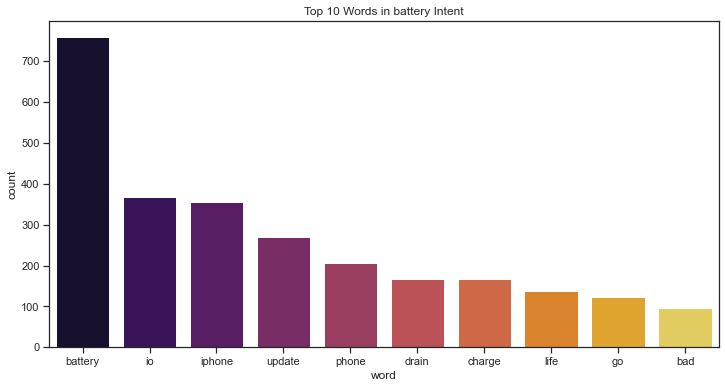

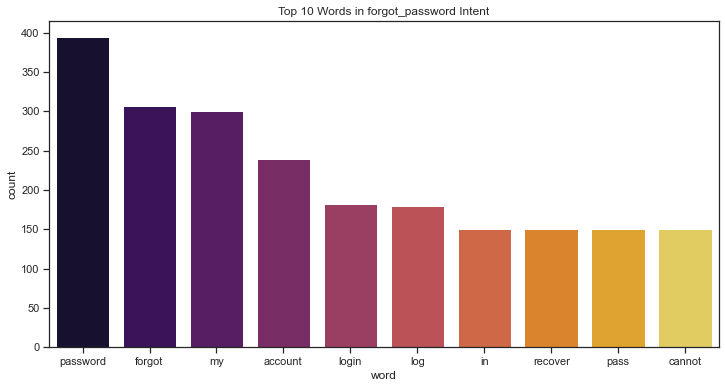

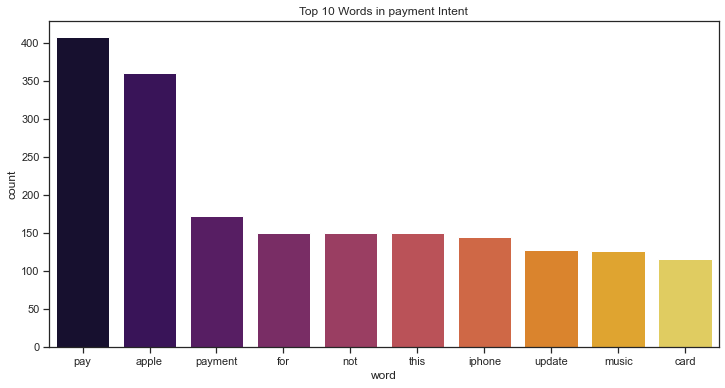

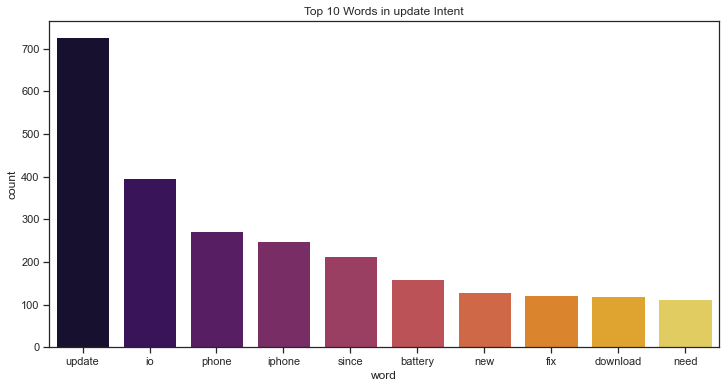

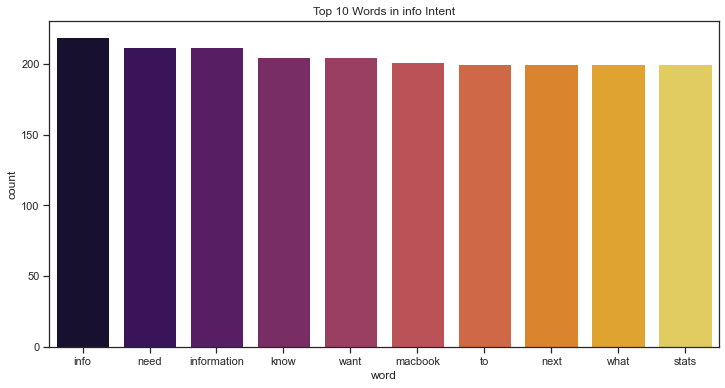

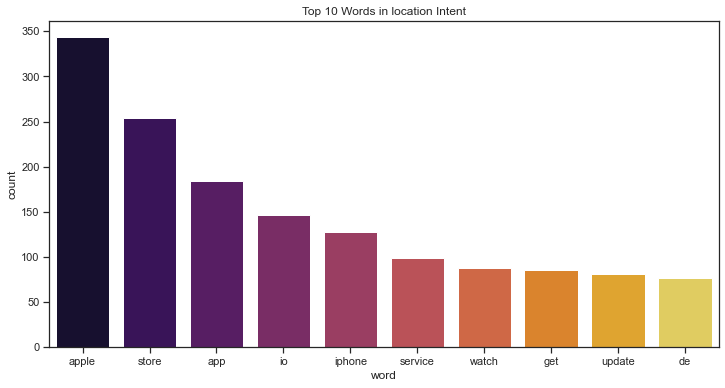

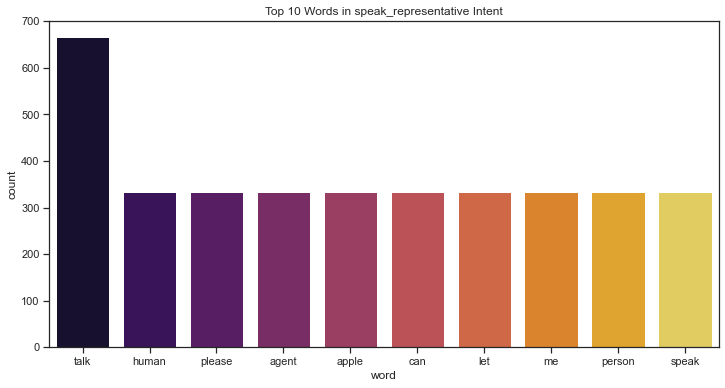

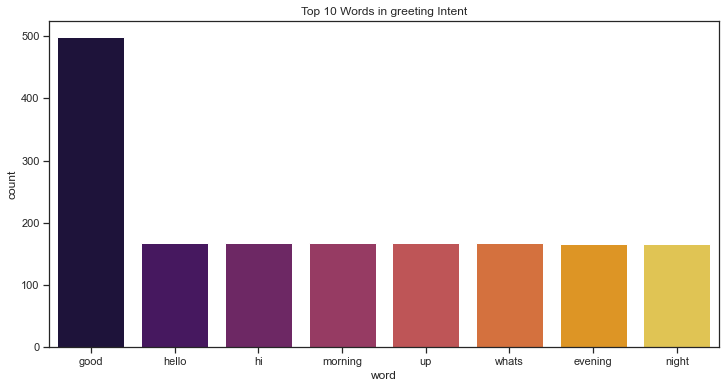

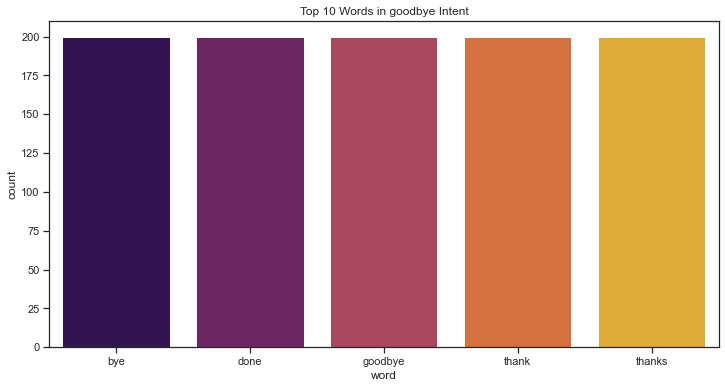

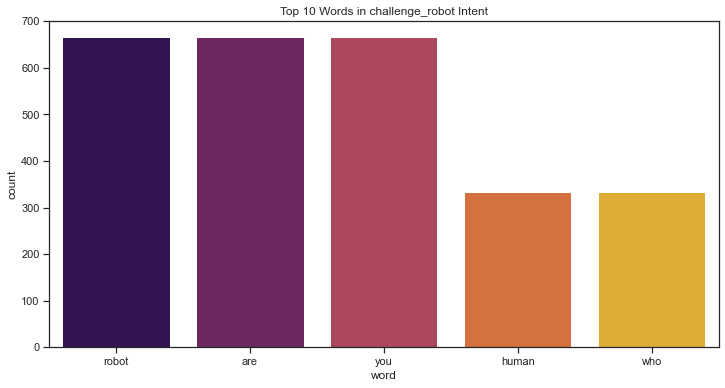

In [91]:
wordranks = {}


def top10_bagofwords(data, output_name, title):
    ''' Taking as input the data and plots the top 10 words based on counts in this text data'''
    bagofwords = CountVectorizer()

    inbound = bagofwords.fit_transform(data)
   
 
    word_counts = np.array(np.sum(inbound, axis=0)).reshape((-1,))
    
    words = np.array(bagofwords.get_feature_names())
    
    words_df = pd.DataFrame({"word":words, 
                             "count":word_counts})
    
    words_rank = words_df.sort_values(by="count", ascending=False)
    
    wordranks[output_name] = words_rank
    
    
    plt.figure(figsize=(12,6))
    sns.barplot(words_rank['word'][:10], words_rank['count'][:10], palette = 'inferno')
    plt.title(title)
 
 
  
    
   

for i in train.columns:
    
    top10_bagofwords(train[i].apply(" ".join), f'bucket_eval/{i}', f'Top 10 Words in {i} Intent')